## Monitor Data Drift using SHAP/LIME

In [1]:
import numpy as np
import pandas as pd
import joblib
import sys, os
sys.path.insert(0, '/home/monte.flora/python_packages/WoF_post')
sys.path.insert(0, '/home/monte.flora/python_packages/ml_workflow')
sys.path.insert(0, '/home/monte.flora/python_packages/wofs_ml_severe')

from wofs_ml_severe.io.load_ml_models import load_ml_model
from wofs_ml_severe.io.io import get_numeric_init_time
from wofs.post.utils import load_yaml
import skexplain 
import shap

from display_names import to_display_name, to_units


lookup_file: /home/monte.flora/python_packages/WoF_post/wofs/data/psadilookup.dat
lookup_file: /home/monte.flora/python_packages/WoF_post/wofs/data/psadilookup.dat


In [2]:
time = 'second_hour'
target = 'all_sig_severe'

ml_config = load_yaml(
    '/home/monte.flora/python_packages/wofs_ml_severe/wofs_ml_severe/conf/ml_config_realtime.yml')
parameters = {
                'target' : target,
                'time' : time, 
                'drop_opt' : '',
                'model_name' : 'LogisticRegression',
                'ml_config' : ml_config,
            }

model_dict = load_ml_model(**parameters)
model = model_dict['model']
features = model_dict['X'].columns
X_train = model_dict['X']

In [3]:
def fix_data(X): 
    X = X.astype({'Initialization Time' : str})
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.reset_index(inplace=True, drop=True)
    
    return X 

In [4]:
# Load data from a recent case. 
path = '/home/monte.flora/python_packages/wofs_ml_severe/tests/test_data/wofs_MLDATA_24_20230303_2330_0000.feather'
df = pd.read_feather(path)
#TEMPORARY FIX!!!!
df['Initialization Time'] = ['2100']*np.shape(df)[0]

X = df[features]
X = fix_data(X)
X = get_numeric_init_time(X)

In [5]:
X['Initialization Time']

0     21
1     21
2     21
3     21
4     21
5     21
6     21
7     21
8     21
9     21
10    21
11    21
12    21
13    21
14    21
15    21
16    21
17    21
18    21
Name: Initialization Time, dtype: int64

In [6]:
pred = model.predict_proba(X)[:,1]*100

In [7]:
pred

array([17.15867159,  8.48080134,  1.53015302,  0.98373061,  0.5144949 ,
        2.55511022,  6.56215822,  0.38358266,  0.5144949 ,  0.63925614,
        0.98373061,  0.98373061,  1.47058824,  3.15560392,  2.55511022,
        3.44036697,  1.741564  ,  2.55511022,  4.75754803])

### Check the results of the transformers 

In [8]:
# As stated above, the masker handles the missing features. In this case, we are using correlations 
# in the dataset to determine the feature groupings. These groups of features are remove or added into 
# sets together. 
X_train = fix_data(X_train)

# As stated above, the masker handles the missing features. In this case, we are using correlations 
# in the dataset to determine the feature groupings. These groups of features are remove or added into 
# sets together. 
shap_kws={'masker' : shap.maskers.Partition(X_train.values.astype(float), 
                                            max_samples=150, clustering="correlation"), 
           'algorithm' : 'permutation'}

In [8]:
display_feature_names = {f: to_display_name(f) for f in X.columns}
display_units = {f: to_units(f) for f in X.columns}

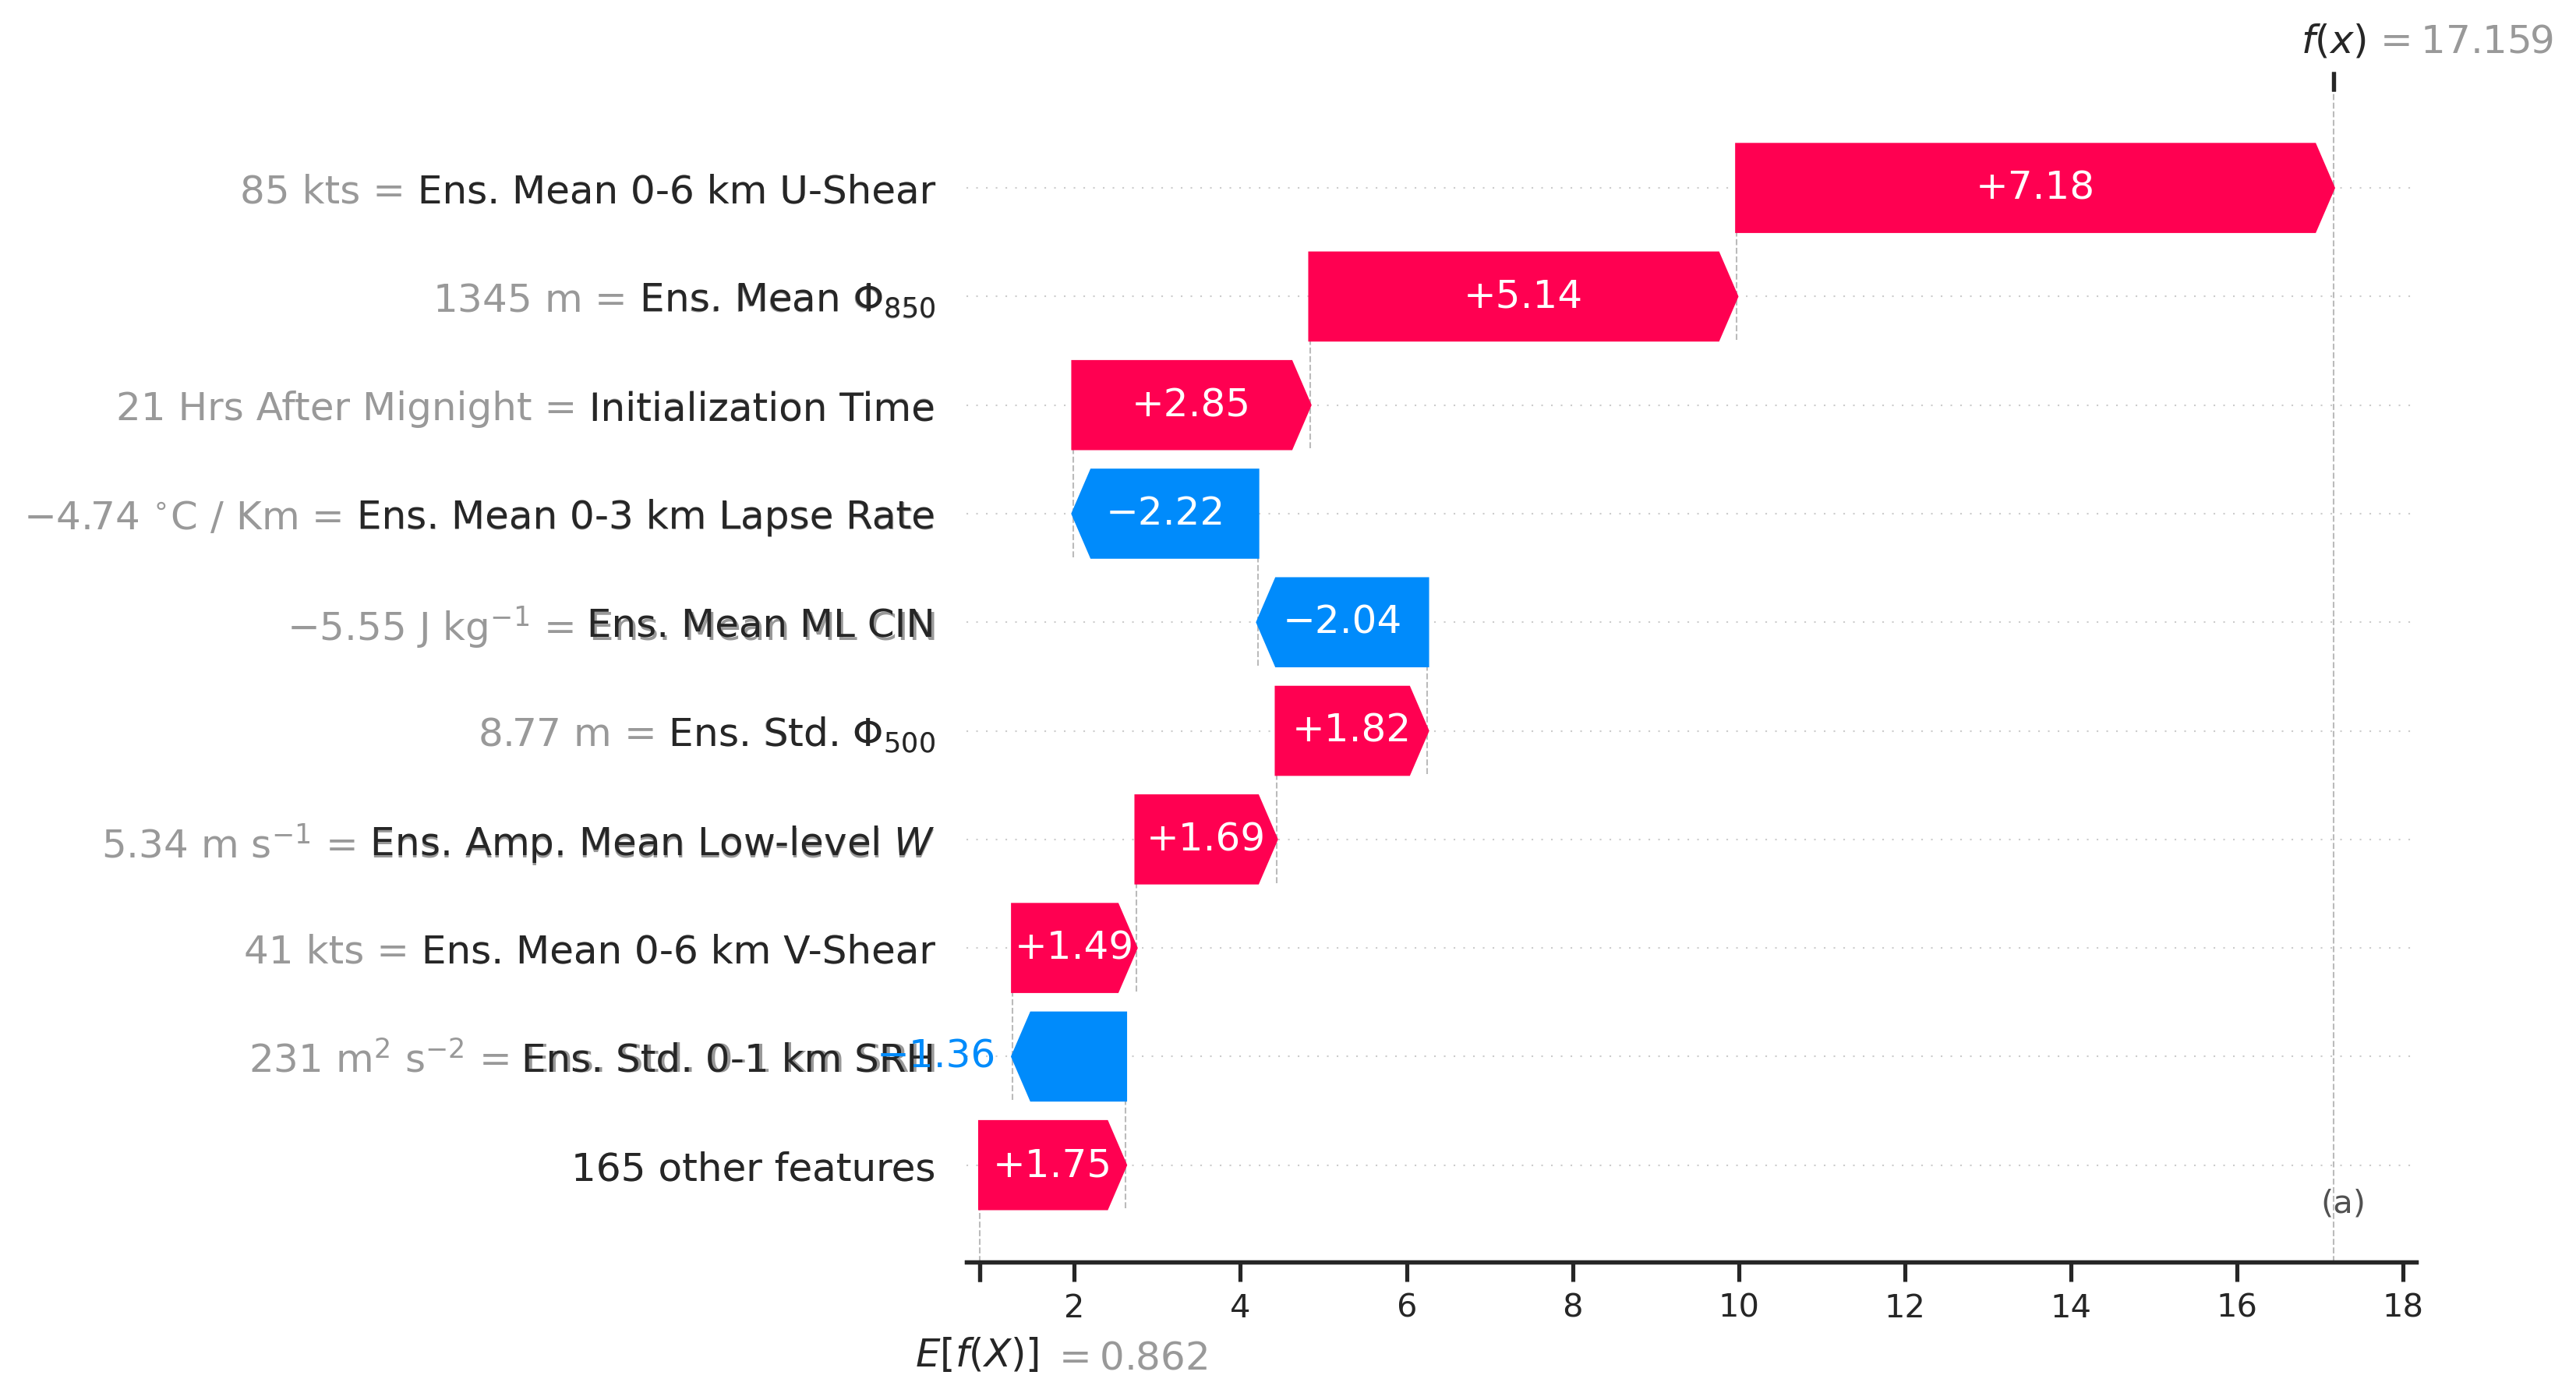

In [9]:
%matplotlib inline

ind = 0 
single_example = X.iloc[[ind]].astype(float)

explainer = skexplain.ExplainToolkit(('LR', model), X=single_example)
contrib_ds = explainer.local_attributions(method='shap', 
                                           shap_kws = shap_kws,
                                          )

fig, axes = explainer.plot_contributions(
    contrib = contrib_ds, 
    display_feature_names = display_feature_names, 
    display_units = display_units, 
)

In [10]:
single_example.columns

Index(['theta_e__ens_mean__spatial_mean', 'u_10__ens_mean__spatial_mean',
       'v_10__ens_mean__spatial_mean',
       'temperature_850__ens_mean__spatial_mean',
       'temperature_700__ens_mean__spatial_mean',
       'temperature_500__ens_mean__spatial_mean',
       'td_850__ens_mean__spatial_mean', 'td_700__ens_mean__spatial_mean',
       'td_500__ens_mean__spatial_mean',
       'mid_level_lapse_rate__ens_mean__spatial_mean',
       ...
       'w_down__time_min__amp_ens_max', 'okubo_weiss__time_min__amp_ens_std',
       'okubo_weiss__time_min__amp_ens_mean',
       'okubo_weiss__time_min__amp_ens_max', 'eccentricity', 'extent',
       'orientation', 'ens_track_prob', 'avg_updraft_track_area',
       'Initialization Time'],
      dtype='object', length=174)